In [1]:
# !pip install gensim

In [2]:
# !pip install pyLDAvis

In [3]:
# !pip install better_profanity

In [4]:
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import random
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import logging
import multiprocessing as mp
from functools import partial
from gensim import corpora
from gensim.models import LdaMulticore
import pyLDAvis.gensim_models
from better_profanity import profanity
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import logging
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
from gensim import corpora
from gensim.models import LdaMulticore, CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
import multiprocessing as mp
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")

In [5]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\RR\AppData\Roaming\nltk_data...


True

In [6]:
# # Read only the first 100,000 rows
# df = pd.read_csv("song_lyrics.csv", nrows=30000)

# # Save it as a new file if needed
# df.to_csv("subset_30k.csv", index=False)

In [7]:
# df = pd.read_csv('random_10k_songs.csv')
df = pd.read_csv('Datasets/subset_30k.csv')

In [8]:
df = df.dropna()

In [9]:
len(df)

29934

In [10]:
df.head()

title  tag     artist  year   views  \
0          Killa Cam  rap    Cam'ron  2004  173166   
1         Can I Live  rap      JAY-Z  1996  468624   
2  Forgive Me Father  rap   Fabolous  2003    4743   
3       Down and Out  rap    Cam'ron  2004  144404   
4             Fly In  rap  Lil Wayne  2005   78271   

                                       features  \
0                   {"Cam\\'ron","Opera Steve"}   
1                                            {}   
2                                            {}   
3  {"Cam\\'ron","Kanye West","Syleena Johnson"}   
4                                            {}   

                                              lyrics  id language_cld3  \
0  [Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...   1            en   
1  [Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...   3            en   
2  Maybe cause I'm eatin\nAnd these bastards fien...   4            en   
3  [Produced by Kanye West and Brian Miller]\n\n[...   5            en   
4  [Intro]\nSo they ask me\n"Young boy\nWhat you ...   6            en   

  language_ft language  
0          en       en  
1          en       en  
2          en       en  
3          en       en  
4          en       en

In [11]:
print(df['tag'].unique())

['rap' 'rb' 'rock' 'pop' 'misc' 'country']


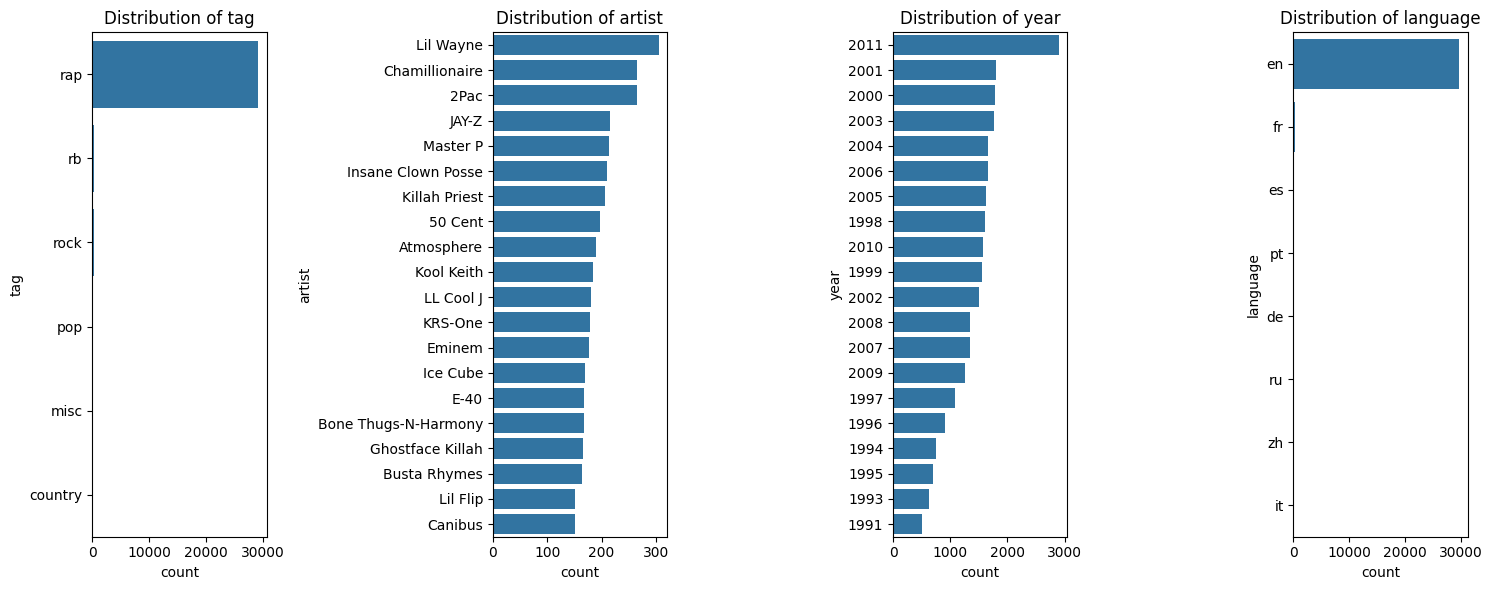

In [12]:
columns_to_plot = ["tag", "artist", "year", "language"]  # Replace with actual column names

# Plot bar charts for categorical distributions
plt.figure(figsize=(15, 6))
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(1, len(columns_to_plot), i)
    sns.countplot(y=df[col], order=df[col].value_counts().index[:20])
    plt.title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

In [13]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\RR\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RR\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\RR\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
# # Simplified preprocessing function without lemmatization
# def preprocess(text):
#     text = text.lower()
#     text = re.sub(r'\W+', ' ', text)  # Remove special characters
#     tokens = text.split()  # Simple tokenization
#     stop_words = set(stopwords.words('english'))
#     tokens = [word for word in tokens if word not in stop_words]
#     return tokens  # Return as list for gensim

# # Apply preprocessing
# df['processed_lyrics'] = df['lyrics'].apply(preprocess)

# # Create dictionary and corpus
# dictionary = corpora.Dictionary(df['processed_lyrics'])
# corpus = [dictionary.doc2bow(text) for text in df['processed_lyrics']]

# # Train LDA model
# lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=2, random_state=42)

# # Visualize the topics
# vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
# pyLDAvis.save_html(vis, 'lda_visualization.html')

# # Print top words for each topic
# for idx, topic in lda_model.print_topics(-1):
#     print(f"Topic {idx}: {topic}")

In [15]:
# !pip install wordcloud

In [16]:
# Initialize the profanity filter
profanity.load_censor_words()

In [20]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\RR\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\RR\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
# Set up logging
logging.basicConfig(
    format='%(asctime)s : %(levelname)s : %(message)s',
    level=logging.INFO)

In [22]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\RR\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [26]:
# Preprocessing function with lemmatization
def preprocess(text):
    """Preprocess text for LDA modeling"""
    # Convert to lowercase
    text = text.lower()
    # Remove special characters
    text = re.sub(r'\W+', ' ', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Remove short words
    tokens = [word for word in tokens if len(word) > 2]

    # Remove offensive words
    tokens = [word for word in tokens if not profanity.contains_profanity(word)]

    return tokens

# Apply preprocessing with progress bar
print("Preprocessing lyrics...")
df['processed_lyrics'] = [preprocess(text) for text in tqdm(df['lyrics'])]

Preprocessing lyrics...


100%|██████████| 29934/29934 [13:58<00:00, 35.69it/s]


In [27]:
# Create dictionary and corpus
print("Creating dictionary and corpus...")
dictionary = corpora.Dictionary(df['processed_lyrics'])
# Filter extremes (optional)
dictionary.filter_extremes(no_below=2, no_above=0.9)
corpus = [dictionary.doc2bow(text) for text in df['processed_lyrics']]

2025-04-07 15:38:15,115 : INFO : adding document #0 to Dictionary<0 unique tokens: []>


Creating dictionary and corpus...


2025-04-07 15:38:15,955 : INFO : adding document #10000 to Dictionary<75050 unique tokens: ['away', 'bad', 'bama', 'bang', 'barnes']...>
2025-04-07 15:38:16,788 : INFO : adding document #20000 to Dictionary<104728 unique tokens: ['away', 'bad', 'bama', 'bang', 'barnes']...>
2025-04-07 15:38:17,622 : INFO : built Dictionary<126599 unique tokens: ['away', 'bad', 'bama', 'bang', 'barnes']...> from 29934 documents (total 8569866 corpus positions)
2025-04-07 15:38:17,622 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<126599 unique tokens: ['away', 'bad', 'bama', 'bang', 'barnes']...> from 29934 documents (total 8569866 corpus positions)", 'datetime': '2025-04-07T15:38:17.622126', 'gensim': '4.3.3', 'python': '3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'created'}
2025-04-07 15:38:17,661 : INFO : discarding 66742 tokens: [('like', 27109), ('edmond', 1), ('geyeahhh', 1), ('driddy', 1), ('ju

Tuning number of topics...


Computing coherence for different topic numbers:   0%|          | 0/8 [00:00<?, ?it/s]2025-04-07 15:38:19,556 : INFO : using asymmetric alpha [0.63060194, 0.36939806]
2025-04-07 15:38:19,556 : INFO : using symmetric eta at 0.5
2025-04-07 15:38:19,558 : INFO : using serial LDA version on this node
2025-04-07 15:38:19,565 : INFO : running online LDA training, 2 topics, 10 passes over the supplied corpus of 29934 documents, updating every 64000 documents, evaluating every ~29934 documents, iterating 100x with a convergence threshold of 0.001000
2025-04-07 15:38:19,565 : INFO : training LDA model using 32 processes
2025-04-07 15:38:37,513 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/29934, outstanding queue size 1
2025-04-07 15:38:37,555 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/29934, outstanding queue size 2
2025-04-07 15:38:37,555 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/29934, outstanding queue size 3


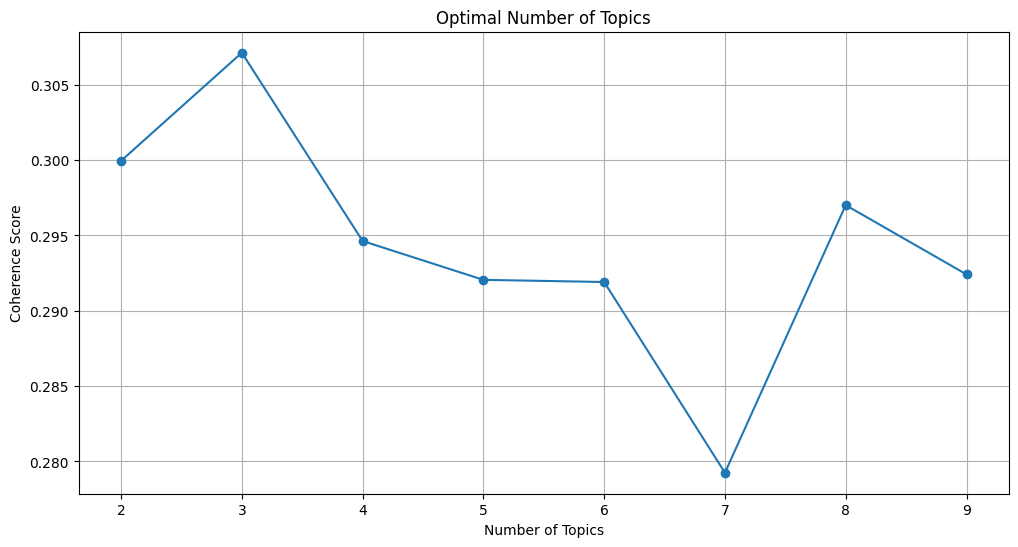

Optimal number of topics: 3


In [28]:
# Function to compute coherence score
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute coherence values for different numbers of topics
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    start : Min num of topics
    step : Step size
    
    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : List of coherence values corresponding to the models
    """
    coherence_values = []
    model_list = []
    
    for num_topics in tqdm(range(start, limit, step), desc="Computing coherence for different topic numbers"):
        model = LdaMulticore(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            workers=mp.cpu_count(),
            random_state=42,
            passes=10,
            alpha='asymmetric',
            iterations=100
        )
        model_list.append(model)
        
        # Compute coherence score
        coherence_model = CoherenceModel(
            model=model, 
            texts=texts, 
            dictionary=dictionary, 
            coherence='c_v'
        )
        coherence_values.append(coherence_model.get_coherence())
    
    return model_list, coherence_values

# Hyperparameter tuning for number of topics
print("Tuning number of topics...")
model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary, 
    corpus=corpus, 
    texts=df['processed_lyrics'], 
    start=2, 
    limit=10, 
    step=1
)

# Plot coherence scores
plt.figure(figsize=(12, 6))
x = range(2, 10, 1)
plt.plot(x, coherence_values, 'o-')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Optimal Number of Topics")
plt.xticks(x)
plt.grid(True)
plt.savefig('topic_coherence.png')
plt.show()

# Find the optimal number of topics
optimal_num_topics = x[coherence_values.index(max(coherence_values))]
print(f"Optimal number of topics: {optimal_num_topics}")

Tuning alpha parameter...


Testing alpha values:   0%|          | 0/5 [00:00<?, ?it/s]2025-04-07 15:48:18,118 : INFO : using symmetric alpha at 0.3333333333333333
2025-04-07 15:48:18,119 : INFO : using symmetric eta at 0.3333333333333333
2025-04-07 15:48:18,122 : INFO : using serial LDA version on this node
2025-04-07 15:48:18,131 : INFO : running online LDA training, 3 topics, 10 passes over the supplied corpus of 29934 documents, updating every 64000 documents, evaluating every ~29934 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-07 15:48:18,131 : INFO : training LDA model using 32 processes
2025-04-07 15:48:36,752 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/29934, outstanding queue size 1
2025-04-07 15:48:36,803 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/29934, outstanding queue size 2
2025-04-07 15:48:36,803 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/29934, outstanding queue size 3
2025-04-07 15:48:

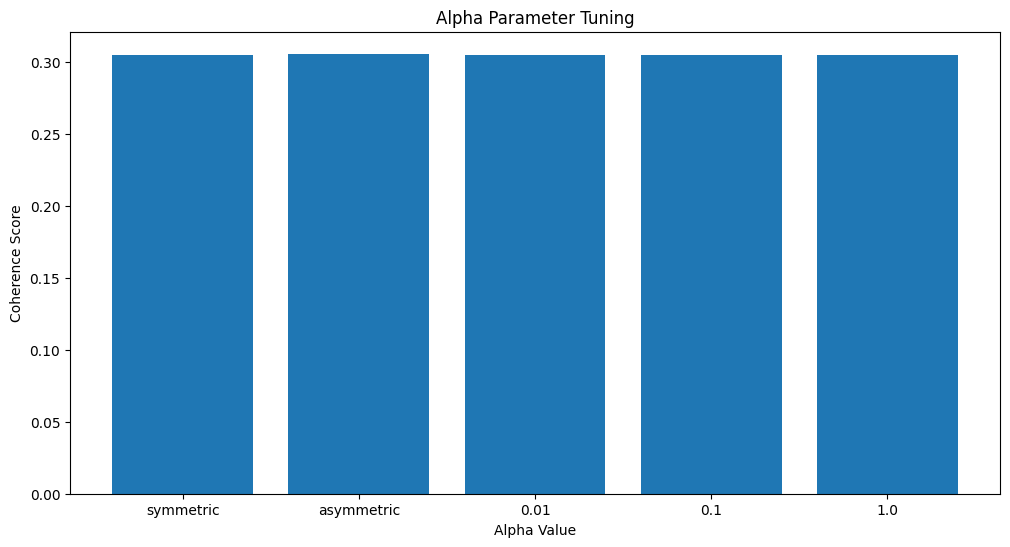

Optimal alpha: asymmetric


In [29]:
# Alpha parameter tuning
print("Tuning alpha parameter...")
alpha_values = ['symmetric', 'asymmetric', 0.01, 0.1, 1.0]
alpha_coherence = []

for alpha in tqdm(alpha_values, desc="Testing alpha values"):
    lda_model = LdaMulticore(
        corpus=corpus, 
        id2word=dictionary,
        num_topics=optimal_num_topics,
        alpha=alpha, 
        workers=mp.cpu_count(),
        random_state=42,
        passes=10
    )
    
    coherence_model = CoherenceModel(
        model=lda_model, 
        texts=df['processed_lyrics'], 
        dictionary=dictionary, 
        coherence='c_v'
    )
    alpha_coherence.append(coherence_model.get_coherence())

# Plot alpha tuning results
plt.figure(figsize=(12, 6))
plt.bar([str(a) for a in alpha_values], alpha_coherence)
plt.xlabel("Alpha Value")
plt.ylabel("Coherence Score")
plt.title("Alpha Parameter Tuning")
plt.savefig('alpha_tuning.png')
plt.show()

# Find optimal alpha
optimal_alpha_idx = alpha_coherence.index(max(alpha_coherence))
optimal_alpha = alpha_values[optimal_alpha_idx]
print(f"Optimal alpha: {optimal_alpha}")

Tuning beta parameter...


Testing beta values:   0%|          | 0/4 [00:00<?, ?it/s]2025-04-07 15:53:29,819 : INFO : using asymmetric alpha [0.47662708, 0.30216947, 0.2212034]
2025-04-07 15:53:29,820 : INFO : using symmetric eta at 0.3333333333333333
2025-04-07 15:53:29,823 : INFO : using serial LDA version on this node
2025-04-07 15:53:29,833 : INFO : running online LDA training, 3 topics, 10 passes over the supplied corpus of 29934 documents, updating every 64000 documents, evaluating every ~29934 documents, iterating 50x with a convergence threshold of 0.001000
2025-04-07 15:53:29,834 : INFO : training LDA model using 32 processes
2025-04-07 15:53:48,755 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/29934, outstanding queue size 1
2025-04-07 15:53:48,799 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/29934, outstanding queue size 2
2025-04-07 15:53:48,799 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/29934, outstanding queue size 3
202

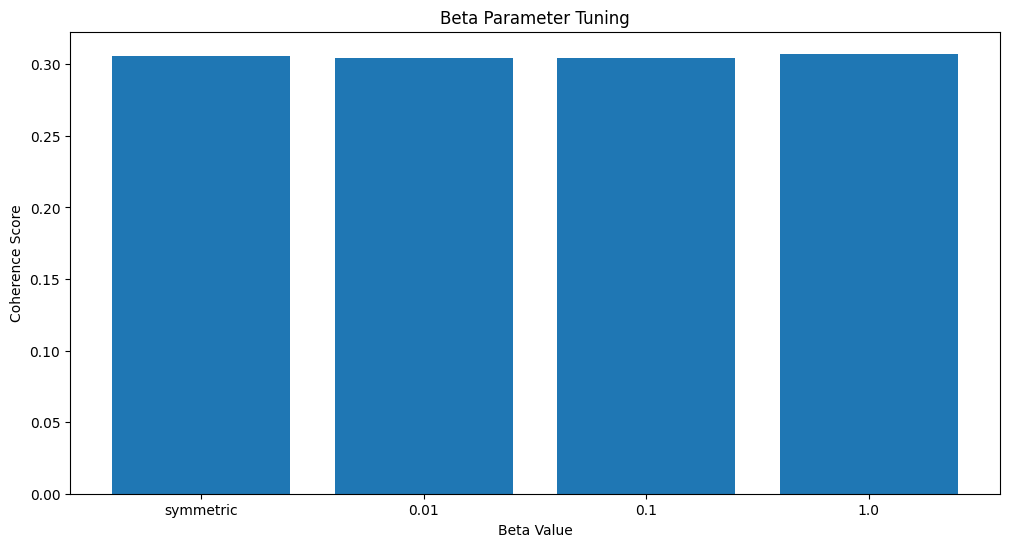

Optimal beta: 1.0


In [30]:
# Beta parameter tuning
print("Tuning beta parameter...")
beta_values = ['symmetric', 0.01, 0.1, 1.0]
beta_coherence = []

for beta in tqdm(beta_values, desc="Testing beta values"):
    lda_model = LdaMulticore(
        corpus=corpus, 
        id2word=dictionary,
        num_topics=optimal_num_topics,
        alpha=optimal_alpha,
        eta=beta,
        workers=mp.cpu_count(),
        random_state=42,
        passes=10
    )
    
    coherence_model = CoherenceModel(
        model=lda_model, 
        texts=df['processed_lyrics'], 
        dictionary=dictionary, 
        coherence='c_v'
    )
    beta_coherence.append(coherence_model.get_coherence())

# Plot beta tuning results
plt.figure(figsize=(12, 6))
plt.bar([str(b) for b in beta_values], beta_coherence)
plt.xlabel("Beta Value")
plt.ylabel("Coherence Score")
plt.title("Beta Parameter Tuning")
plt.savefig('beta_tuning.png')
plt.show()

# Find optimal beta
optimal_beta_idx = beta_coherence.index(max(beta_coherence))
optimal_beta = beta_values[optimal_beta_idx]
print(f"Optimal beta: {optimal_beta}")

In [31]:
# Train final LDA model with optimal parameters
print("Training final LDA model with optimal parameters...")
final_lda_model = LdaMulticore(
    corpus=corpus, 
    id2word=dictionary,
    num_topics=optimal_num_topics,
    alpha=optimal_alpha,
    eta=optimal_beta,
    workers=mp.cpu_count(),
    random_state=42,
    passes=20,
    iterations=200
)

# Print topics
print("\nFinal LDA Model Topics:")
for idx, topic in final_lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")

2025-04-07 15:57:42,400 : INFO : using asymmetric alpha [0.47662708, 0.30216947, 0.2212034]
2025-04-07 15:57:42,403 : INFO : using serial LDA version on this node
2025-04-07 15:57:42,412 : INFO : running online LDA training, 3 topics, 20 passes over the supplied corpus of 29934 documents, updating every 64000 documents, evaluating every ~29934 documents, iterating 200x with a convergence threshold of 0.001000
2025-04-07 15:57:42,412 : INFO : training LDA model using 32 processes


Training final LDA model with optimal parameters...


2025-04-07 15:58:01,276 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/29934, outstanding queue size 1
2025-04-07 15:58:01,323 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/29934, outstanding queue size 2
2025-04-07 15:58:01,323 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/29934, outstanding queue size 3
2025-04-07 15:58:01,369 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/29934, outstanding queue size 4
2025-04-07 15:58:01,370 : INFO : PROGRESS: pass 0, dispatched chunk #4 = documents up to #10000/29934, outstanding queue size 5
2025-04-07 15:58:01,411 : INFO : PROGRESS: pass 0, dispatched chunk #5 = documents up to #12000/29934, outstanding queue size 6
2025-04-07 15:58:01,411 : INFO : PROGRESS: pass 0, dispatched chunk #6 = documents up to #14000/29934, outstanding queue size 7
2025-04-07 15:58:01,412 : INFO : PROGRESS: pass 0, dispatched chunk #7 = documents up to #16000/29934, outst


Final LDA Model Topics:
Topic 0: 0.010*"got" + 0.010*"get" + 0.008*"know" + 0.007*"one" + 0.006*"cause" + 0.006*"verse" + 0.006*"time" + 0.006*"man" + 0.005*"see" + 0.005*"make"
Topic 1: 0.019*"get" + 0.018*"got" + 0.010*"know" + 0.007*"cause" + 0.007*"back" + 0.006*"see" + 0.006*"yeah" + 0.006*"verse" + 0.005*"money" + 0.005*"let"
Topic 2: 0.014*"girl" + 0.013*"know" + 0.013*"got" + 0.012*"baby" + 0.011*"yeah" + 0.011*"love" + 0.011*"get" + 0.008*"let" + 0.007*"chorus" + 0.007*"verse"


In [32]:
# Create pyLDAvis visualization
print("Creating interactive visualization...")
vis = pyLDAvis.gensim_models.prepare(final_lda_model, corpus, dictionary)
pyLDAvis.save_html(vis, 'lda_visualization.html')
print("Interactive visualization saved as 'lda_visualization.html'")

Creating interactive visualization...
Interactive visualization saved as 'lda_visualization.html'


In [33]:
# Generate word clouds for each topic
print("Generating word clouds for topics...")
def generate_wordcloud(lda_model, topic_id):
    """Generate word cloud for a specific topic"""
    topic_words = dict(lda_model.show_topic(topic_id, 30))
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        colormap='viridis',
        max_words=50,
        contour_width=3
    ).generate_from_frequencies(topic_words)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Topic {topic_id}')
    plt.tight_layout()
    plt.savefig(f'wordcloud_topic_{topic_id}.png')
    plt.close()

# Generate word cloud for each topic
for i in range(optimal_num_topics):
    generate_wordcloud(final_lda_model, i)

Generating word clouds for topics...


In [34]:
# Predict topic distributions for each document
print("Predicting topic distributions for documents...")
doc_topics = []
for i, doc in enumerate(corpus):
    topic_dist = final_lda_model.get_document_topics(doc)
    topic_dist = sorted(topic_dist, key=lambda x: x[1], reverse=True)
    doc_topics.append((i, topic_dist))

Predicting topic distributions for documents...



Dominant Topics for Each Document:
Document 0: '[Chorus: Opera Steve & Cam'ron]
Killa Cam, Killa C...' - Topic 1 (Probability: 0.9984)
Document 1: '[Produced by Irv Gotti]

[Intro]
Yeah, hah, yeah, ...' - Topic 0 (Probability: 0.7098)
Document 2: 'Maybe cause I'm eatin
And these bastards fiend for...' - Topic 1 (Probability: 0.9096)
Document 3: '[Produced by Kanye West and Brian Miller]

[Intro:...' - Topic 1 (Probability: 0.6722)
Document 4: '[Intro]
So they ask me
"Young boy
What you gon' do...' - Topic 1 (Probability: 0.6936)
Document 5: '[Intro: Lil Wayne]
Haha
Uh-huh
No homo (Young Mula...' - Topic 2 (Probability: 0.9968)
Document 6: '[Intro: Pusha T]
No, no, no!
I told you, I lived t...' - Topic 0 (Probability: 0.6774)
Document 7: '[Verse 1: Cam'ron]
Killa, Dipset
Man I spit that p...' - Topic 1 (Probability: 0.9937)
Document 8: '[Verse 1]
Ay yo you wonder who I are
I guzzle up a...' - Topic 1 (Probability: 0.6457)
Document 9: '[Chorus: Jaheim]
Now Lord you know, just how hard .

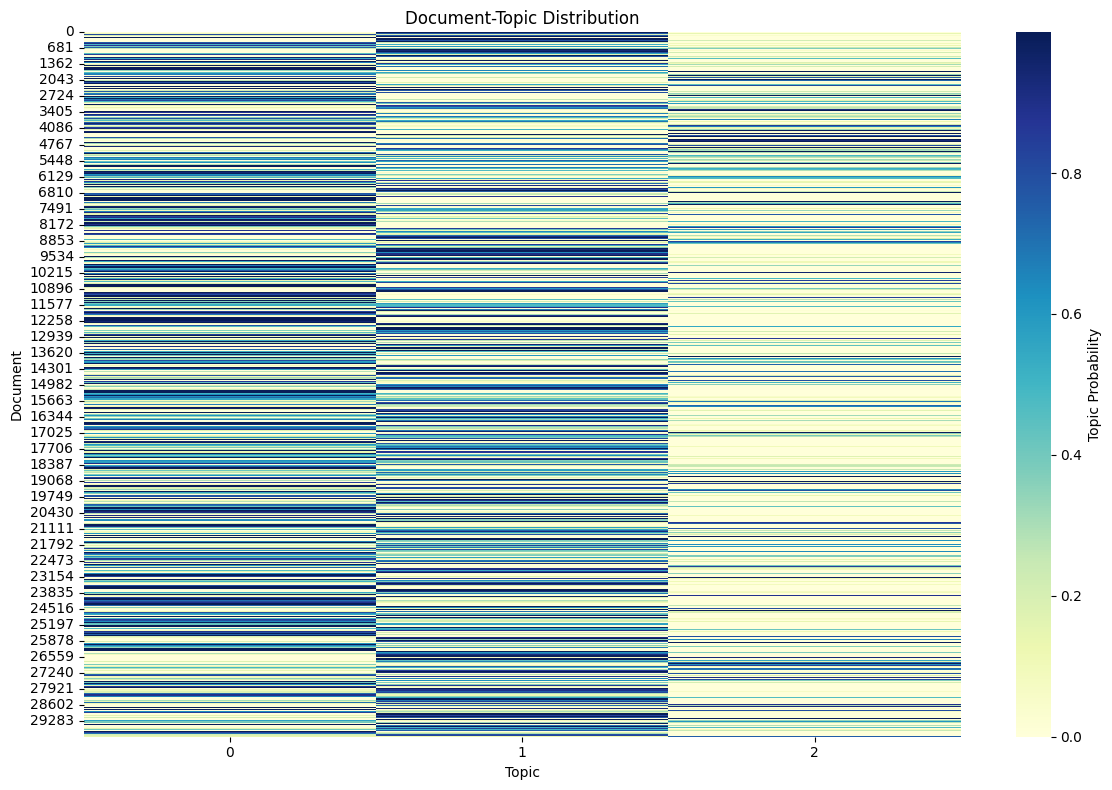

In [35]:
# Display dominant topic for each document
print("\nDominant Topics for Each Document:")
for i, (doc_idx, topic_dist) in enumerate(doc_topics):
    if topic_dist:  # Check if topic_dist is not empty
        dominant_topic = topic_dist[0][0]
        dominant_prob = topic_dist[0][1]
        try:
            # Try to access the document text
            doc_text = df['lyrics'][doc_idx][:50]
            print(f"Document {doc_idx}: '{doc_text}...' - Topic {dominant_topic} (Probability: {dominant_prob:.4f})")
        except KeyError:
            # Skip documents that don't exist in the DataFrame
            print(f"Skipping document {doc_idx} - not found in DataFrame")
            continue

# Create document-topic heatmap
print("Creating document-topic heatmap...")
doc_topic_matrix = np.zeros((len(corpus), optimal_num_topics))
for i, doc in enumerate(corpus):
    for topic, prob in final_lda_model.get_document_topics(doc):
        doc_topic_matrix[i, topic] = prob

plt.figure(figsize=(12, 8))
sns.heatmap(doc_topic_matrix, cmap="YlGnBu", cbar_kws={'label': 'Topic Probability'})
plt.xlabel("Topic")
plt.ylabel("Document")
plt.title("Document-Topic Distribution")
plt.tight_layout()
plt.savefig('doc_topic_heatmap.png')
plt.show()

Calculating overall topic distribution...


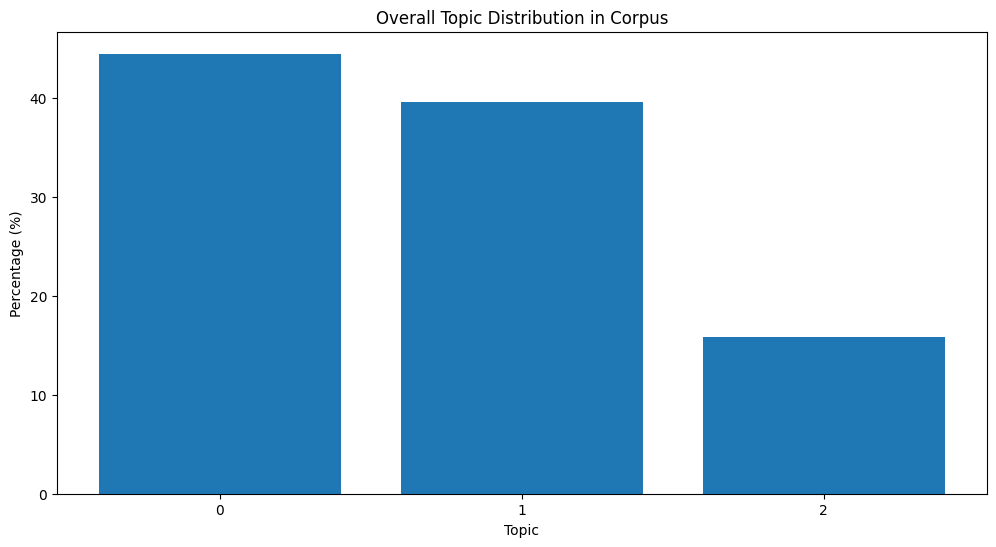

In [36]:
# Calculate topic distribution across corpus
print("Calculating overall topic distribution...")
topic_counts = np.zeros(optimal_num_topics)
for doc in corpus:
    topic_dist = final_lda_model.get_document_topics(doc, minimum_probability=0.0)
    for topic, prob in topic_dist:
        topic_counts[topic] += prob

# Normalize to get percentages
topic_percentages = (topic_counts / topic_counts.sum()) * 100

# Plot overall topic distribution
plt.figure(figsize=(12, 6))
plt.bar(range(optimal_num_topics), topic_percentages)
plt.xlabel("Topic")
plt.ylabel("Percentage (%)")
plt.title("Overall Topic Distribution in Corpus")
plt.xticks(range(optimal_num_topics))
plt.savefig('topic_distribution.png')
plt.show()

In [37]:
print("LDA topic modeling analysis complete!")

LDA topic modeling analysis complete!


In [38]:
df

title  tag             artist  year   views  \
0                           Killa Cam  rap            Cam'ron  2004  173166   
1                          Can I Live  rap              JAY-Z  1996  468624   
2                   Forgive Me Father  rap           Fabolous  2003    4743   
3                        Down and Out  rap            Cam'ron  2004  144404   
4                              Fly In  rap          Lil Wayne  2005   78271   
...                               ...  ...                ...   ...     ...   
29995                     I Dont Hang  rap           Soopafly  1996     840   
29996         Dont Test / Wu Stallion  rap     Suga Bang Bang  2000    1279   
29997                       Dont Ever  rap    Black Azz Chill  1997    1476   
29998               Dirty And Thirsty  rap  Ol' Dirty Bastard  2004     403   
29999  Electric Kingdom vocal version  rap        Twilight 22  1983     288   

                                           features  \
0                       {"Cam\\'ron","Opera Steve"}   
1                                                {}   
2                                                {}   
3      {"Cam\\'ron","Kanye West","Syleena Johnson"}   
4                                                {}   
...                                             ...   
29995                                            {}   
29996                                            {}   
29997                                            {}   
29998   {"Ol\\' Dirty Bastard","Thirstin Howl III"}   
29999                                            {}   

                                                  lyrics     id language_cld3  \
0      [Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...      1            en   
1      [Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...      3            en   
2      Maybe cause I'm eatin\nAnd these bastards fien...      4            en   
3      [Produced by Kanye West and Brian Miller]\n\n[...      5            en   
4      [Intro]\nSo they ask me\n"Young boy\nWhat you ...      6            en   
...                                                  ...    ...           ...   
29995  Intro:\nScratching\nYes yes y'all (x8)\n\nVers...  31690            en   
29996  [Suga Bang Bang]\nIt's time, it's time to come...  31691            en   
29997  Now you can bet that I will never trust no bro...  31692            en   
29998  [Intro: Thirstin Howl III]\nYeah, this what ha...  31693            en   
29999  Electric kingdom\n\nDeep in the city people li...  31694            en   

      language_ft language                                   processed_lyrics  
0              en       en  [chorus, opera, steve, cam, ron, killa, cam, k...  
1              en       en  [produced, irv, gotti, intro, yeah, hah, yeah,...  
2              en       en  [maybe, cause, eatin, fiend, grub, carry, pump...  
3              en       en  [produced, kanye, west, brian, miller, intro, ...  
4              en       en  [intro, ask, young, boy, gon, second, time, ar...  
...           ...      ...                                                ...  
29995          en       en  [intro, scratching, yes, yes, verse, ruff, rou...  
29996          en       en  [suga, bang, bang, time, time, come, summer, t...  
29997          en       en  [bet, never, trust, broad, think, simpin, rose...  
29998          en       en  [intro, thirstin, howl, iii, yeah, happens, di...  
29999          en       en  [electric, kingdom, deep, city, people, live, ...  

[29934 rows x 12 columns]

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from gensim.models import LdaMulticore
from gensim import corpora

# Assuming you have your DataFrame 'df' with columns: 
# title, tag, artist, year, views, features, lyrics, id, language_cld3, language_ft, language
# And your LDA model 'final_lda_model' and 'dictionary' are already trained

# 1. Topic Distribution by Artist
def get_dominant_topics(lyrics_list):
    dominant_topics = []
    for lyrics in lyrics_list:
        # Check if lyrics is a list of tokens or a string
        if isinstance(lyrics, list):
            tokens = lyrics
        else:
            tokens = lyrics.split()
        
        bow = dictionary.doc2bow(tokens)
        topic_dist = final_lda_model.get_document_topics(bow)
        if topic_dist:
            dominant_topic = max(topic_dist, key=lambda x: x[1])[0]
            dominant_topics.append(dominant_topic)
    return dominant_topics

# Group by artist and calculate dominant topics
artist_topics = df.groupby('artist')['processed_lyrics'].apply(get_dominant_topics)

# Count topics for each artist
artist_topic_counts = {}
for artist, topics in artist_topics.items():
    topic_counts = pd.Series(topics).value_counts().to_dict()
    artist_topic_counts[artist] = topic_counts

# Convert to DataFrame for visualization
artist_topic_df = pd.DataFrame(artist_topic_counts).fillna(0).T

<Figure size 3000x2000 with 0 Axes>

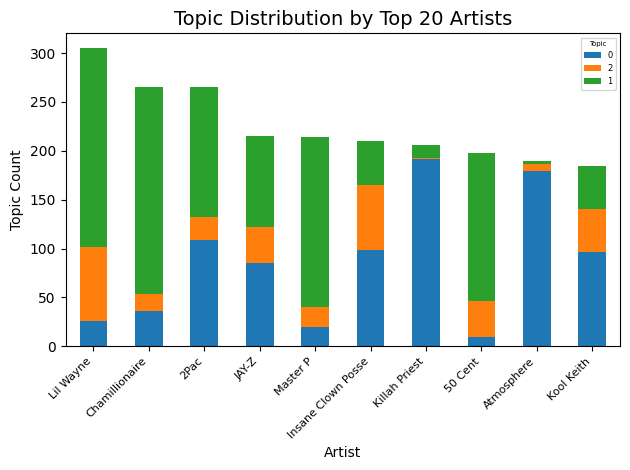

In [40]:
# Visualize topic distribution by artist (top 10 artists by song count)
top_artists = df['artist'].value_counts().head(10).index
plt.figure(figsize=(30, 20))  # Increased figure size for better visibility
artist_topic_df.loc[top_artists].plot(kind='bar', stacked=True)
plt.title('Topic Distribution by Top 20 Artists', fontsize=14)
plt.xlabel('Artist', fontsize=10)
plt.ylabel('Topic Count', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend(title='Topic', fontsize=6, title_fontsize=5, loc='upper right')  # Smaller legend font
plt.tight_layout()
plt.savefig('artist_topic_distribution.png', dpi=300)  # Higher resolution
plt.show()

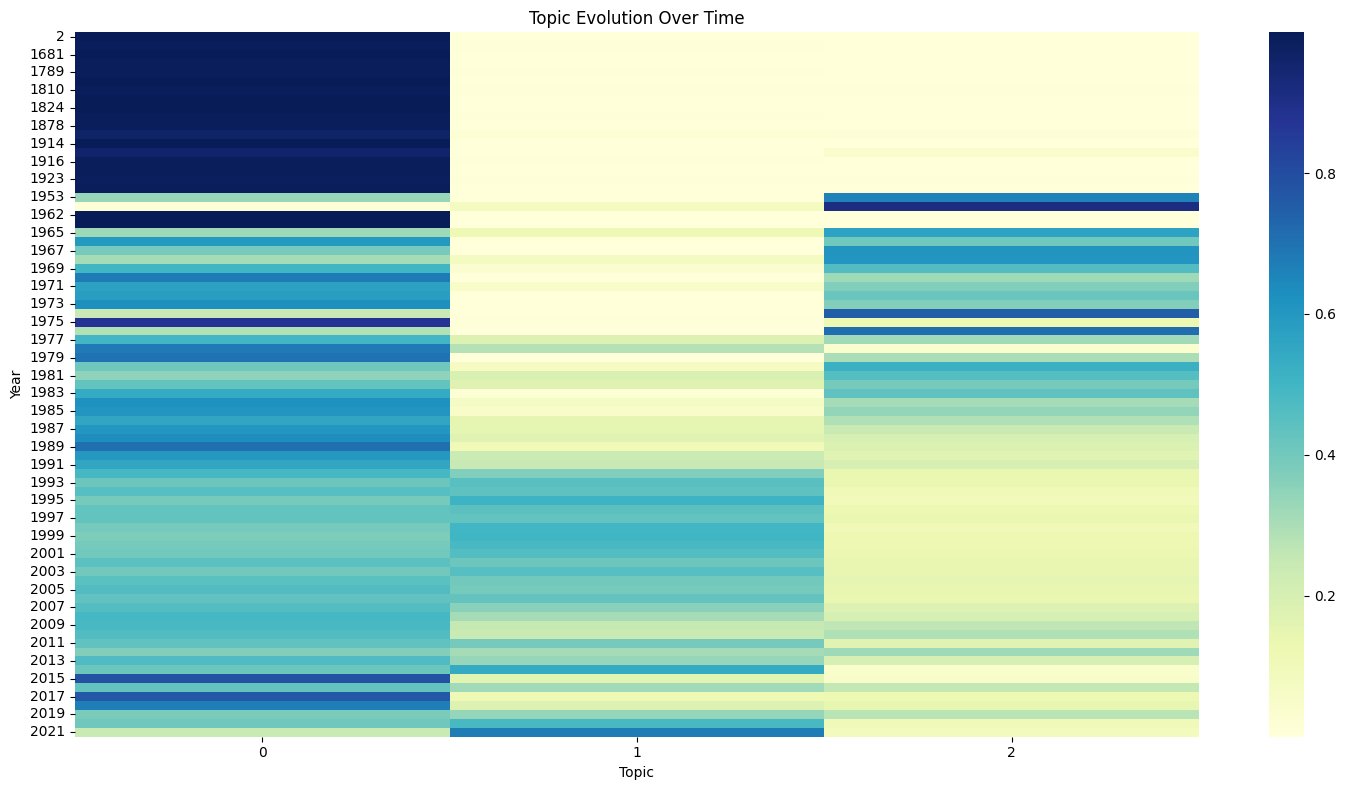

In [41]:
# 2. Topic Evolution Over Time
def get_average_topic_distribution(lyrics_list):
    topic_distributions = []
    for lyrics in lyrics_list:
        if isinstance(lyrics, list):
            tokens = lyrics
        else:
            tokens = lyrics.split()
            
        bow = dictionary.doc2bow(tokens)
        topic_dist = final_lda_model.get_document_topics(bow, minimum_probability=0.0)
        topic_dist_dict = {topic_id: prob for topic_id, prob in topic_dist}
        topic_distributions.append([topic_dist_dict.get(i, 0.0) for i in range(final_lda_model.num_topics)])
    
    return pd.DataFrame(topic_distributions).mean()

# Group by year and calculate average topic distribution
year_topics = df.groupby('year')['processed_lyrics'].apply(get_average_topic_distribution).unstack()

# Visualize topic evolution over time
plt.figure(figsize=(15, 8))
sns.heatmap(year_topics, cmap="YlGnBu", annot=False)
plt.title("Topic Evolution Over Time")
plt.xlabel("Topic")
plt.ylabel("Year")
plt.tight_layout()
plt.savefig('topic_evolution.png')
plt.show()

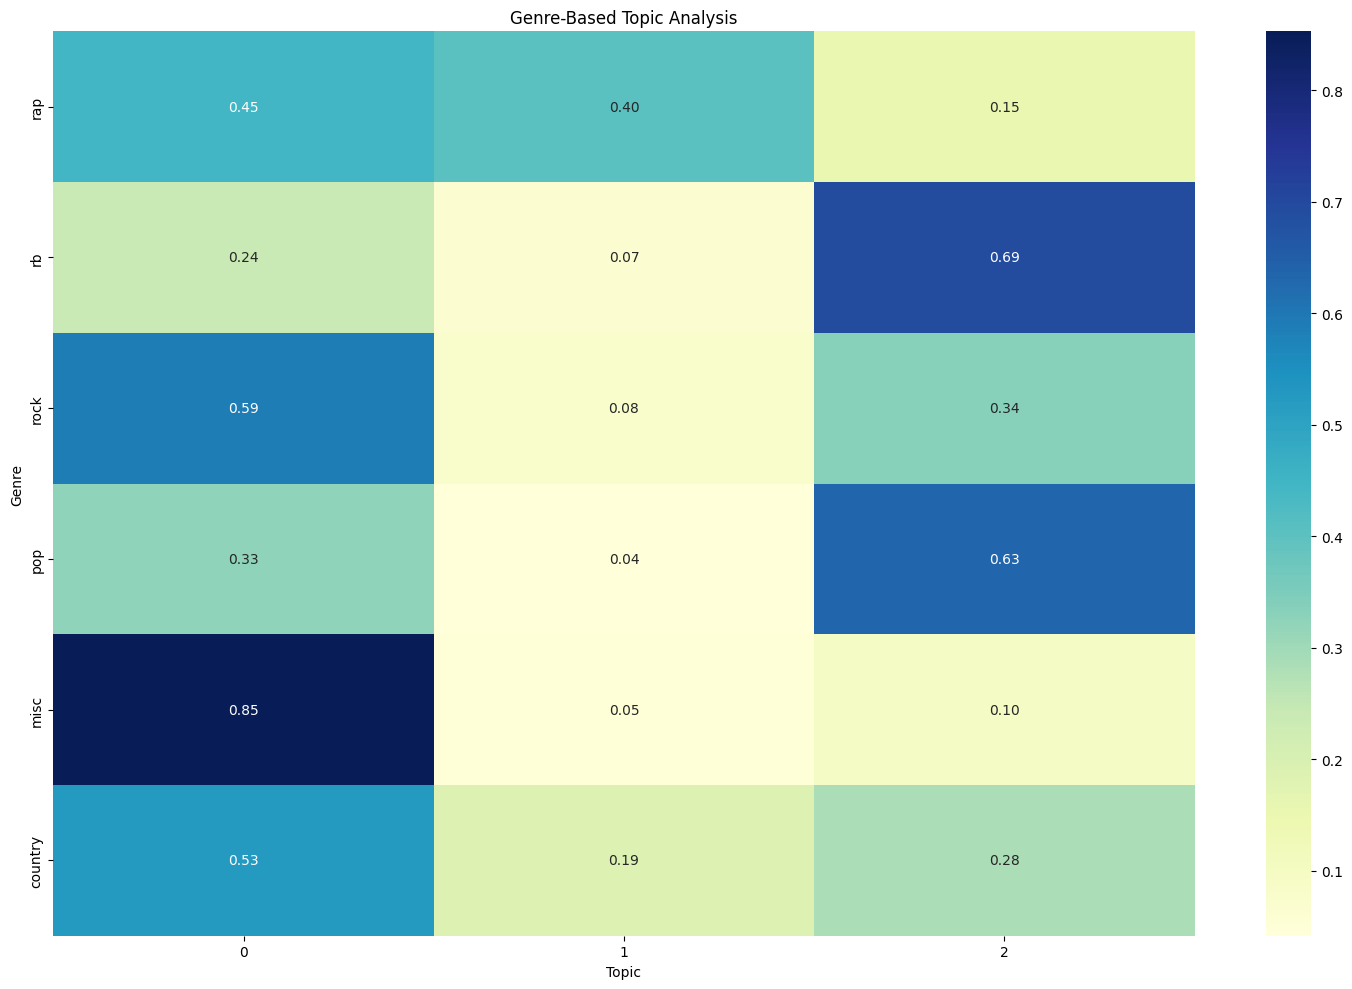

In [42]:
# 3. Genre-Topic Correlation
# Group by genre (tag) and calculate average topic distribution
genre_topics = df.groupby('tag')['processed_lyrics'].apply(get_average_topic_distribution).unstack()

# Visualize genre-based topic analysis (top 15 genres)
top_genres = df['tag'].value_counts().head(15).index
plt.figure(figsize=(15, 10))
sns.heatmap(genre_topics.loc[top_genres], cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Genre-Based Topic Analysis")
plt.xlabel("Topic")
plt.ylabel("Genre")
plt.tight_layout()
plt.savefig('genre_topic_analysis.png')
plt.show()

2025-04-07 16:00:55,136 : INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-07 16:00:55,143 : INFO : Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


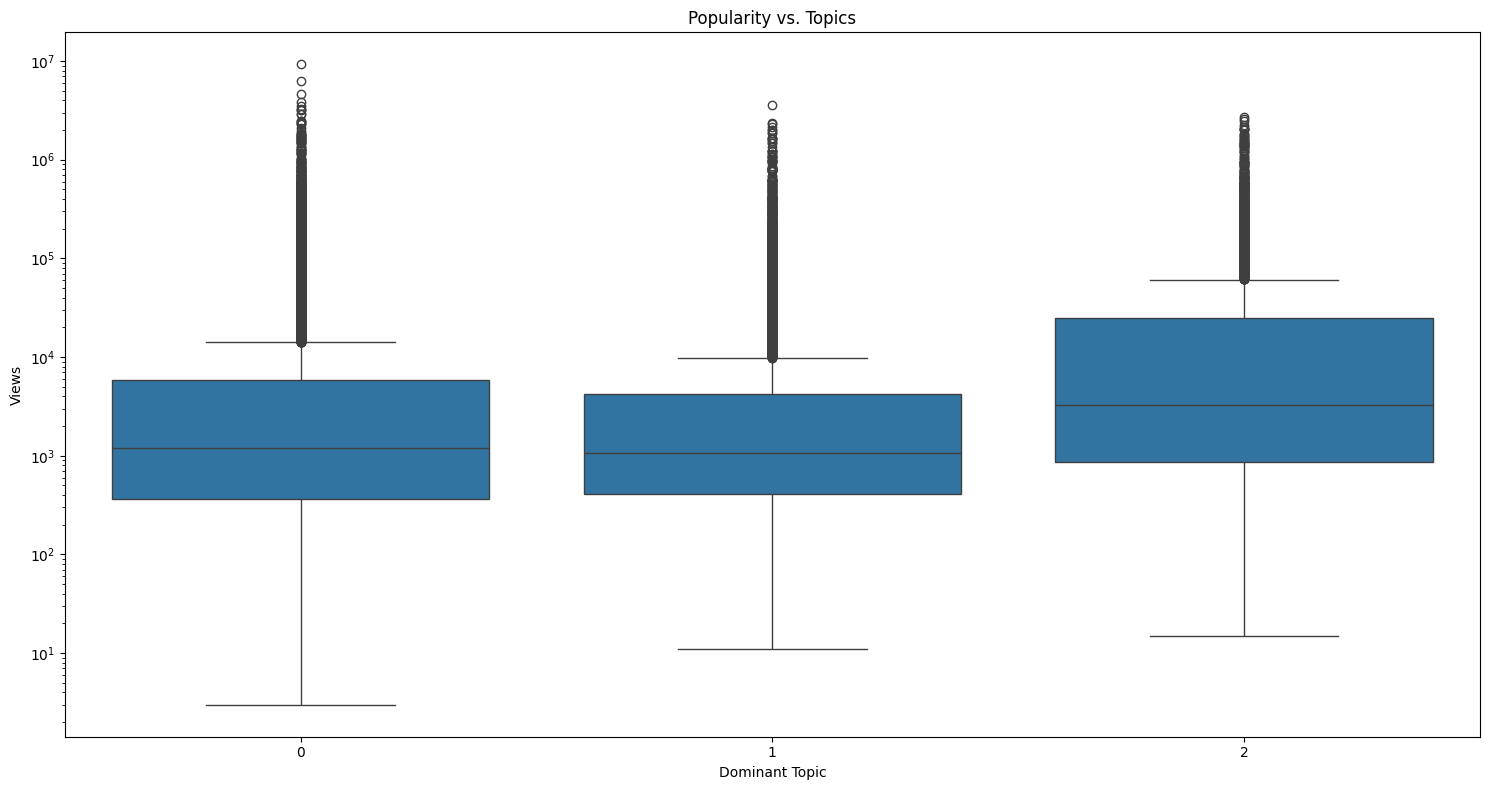

In [43]:
# 4. Popularity Analysis
def get_dominant_topic(lyrics):
    if isinstance(lyrics, list):
        tokens = lyrics
    else:
        tokens = lyrics.split()
        
    bow = dictionary.doc2bow(tokens)
    topic_dist = final_lda_model.get_document_topics(bow)
    if topic_dist:
        return max(topic_dist, key=lambda x: x[1])[0]
    return None

# Create a DataFrame for popularity vs. topics analysis
df['dominant_topic'] = df['processed_lyrics'].apply(get_dominant_topic)
topic_popularity = df[['views', 'dominant_topic']].dropna()

# Visualize popularity vs. topics
plt.figure(figsize=(15, 8))
sns.boxplot(x='dominant_topic', y='views', data=topic_popularity)
plt.title("Popularity vs. Topics")
plt.xlabel("Dominant Topic")
plt.ylabel("Views")
plt.yscale('log')  # Log scale for better visualization if views vary widely
plt.tight_layout()
plt.savefig('popularity_vs_topics.png')
plt.show()

In [44]:
# # 5. Feature Engineering for Recommendation
# def get_topic_distribution_vector(lyrics):
#     if isinstance(lyrics, list):
#         tokens = lyrics
#     else:
#         tokens = lyrics.split()
        
#     bow = dictionary.doc2bow(tokens)
#     topic_dist = final_lda_model.get_document_topics(bow, minimum_probability=0.0)
#     return [prob for _, prob in sorted(topic_dist)]

# # Add topic features to the DataFrame
# df['topic_features'] = df['processed_lyrics'].apply(get_topic_distribution_vector)

# # Display sample of the DataFrame with topic features
# display(df[['title', 'artist', 'year', 'views', 'topic_features']].head())

In [45]:
# 7. Topic Word Clouds
from wordcloud import WordCloud

# Generate word clouds for each topic
def generate_topic_wordcloud(final_lda_model, topic_id, top_n=50):
    topic_words = dict(final_lda_model.show_topic(topic_id, top_n))
    
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        colormap='viridis',
        max_words=top_n
    ).generate_from_frequencies(topic_words)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Topic {topic_id}')
    plt.tight_layout()
    plt.savefig(f'wordcloud_topic_{topic_id}.png')
    plt.close()

# Generate word cloud for each topic
for i in range(final_lda_model.num_topics):
    generate_topic_wordcloud(final_lda_model, i)

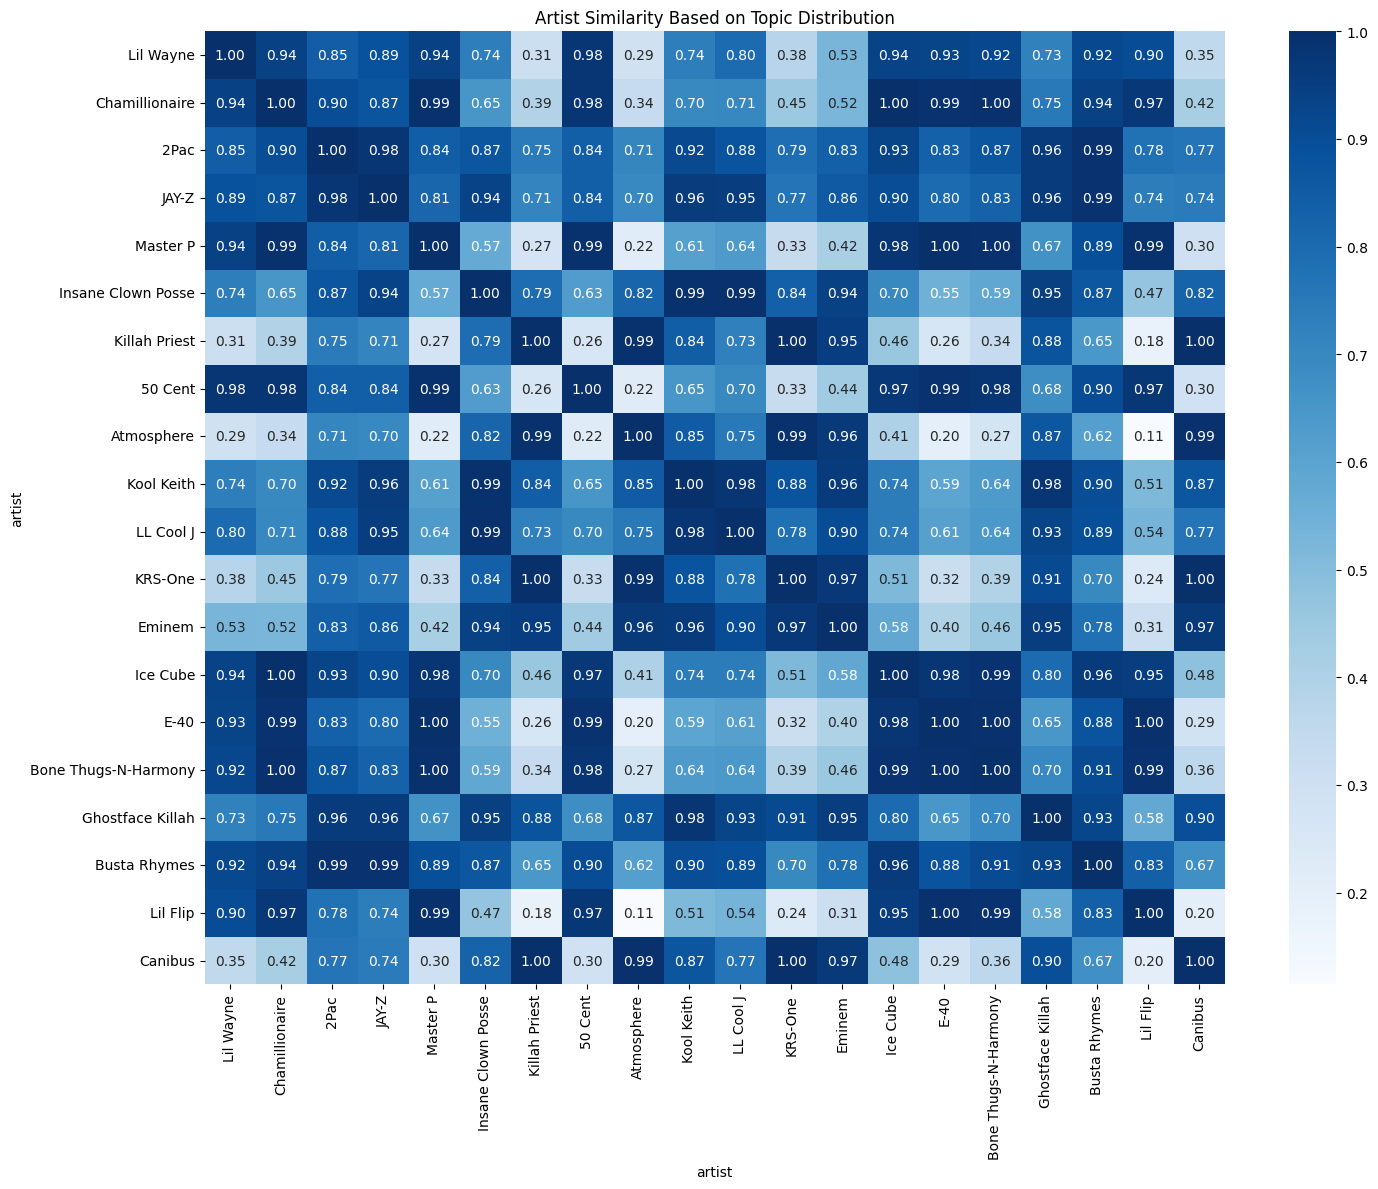

In [46]:
# 8. Artist Similarity Based on Topics
from sklearn.metrics.pairwise import cosine_similarity

# Get average topic distribution for each artist
artist_topic_vectors = {}
for artist in df['artist'].unique():
    artist_lyrics = df[df['artist'] == artist]['processed_lyrics']
    topic_vectors = []
    
    for lyrics in artist_lyrics:
        if isinstance(lyrics, list):
            tokens = lyrics
        else:
            tokens = lyrics.split()
            
        bow = dictionary.doc2bow(tokens)
        topic_dist = final_lda_model.get_document_topics(bow, minimum_probability=0.0)
        topic_vector = [0] * final_lda_model.num_topics
        for topic_id, prob in topic_dist:
            topic_vector[topic_id] = prob
        topic_vectors.append(topic_vector)
    
    if topic_vectors:
        artist_topic_vectors[artist] = np.mean(topic_vectors, axis=0)

# Convert to DataFrame
artist_topics_df = pd.DataFrame.from_dict(artist_topic_vectors, orient='index')

# Calculate similarity matrix
similarity_matrix = cosine_similarity(artist_topics_df)
artist_similarity = pd.DataFrame(
    similarity_matrix, 
    index=artist_topics_df.index, 
    columns=artist_topics_df.index
)

# Visualize similarity for top artists
top_artists = df['artist'].value_counts().head(20).index
plt.figure(figsize=(15, 12))
sns.heatmap(
    artist_similarity.loc[top_artists, top_artists], 
    annot=True, 
    cmap='Blues', 
    fmt=".2f"
)
plt.title('Artist Similarity Based on Topic Distribution')
plt.tight_layout()
plt.savefig('artist_similarity.png')
plt.show()

In [47]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Function to get document-topic matrix
def get_document_topic_matrix(df, lda_model, dictionary):
    """Get the document-topic matrix from the LDA model"""
    doc_topic_matrix = np.zeros((len(df), lda_model.num_topics))
    
    for i, doc in enumerate(df['processed_lyrics']):
        # Convert document to bag of words
        if isinstance(doc, str):
            doc = doc.split()
        bow = dictionary.doc2bow(doc)
        
        # Get topic distribution
        topic_dist = lda_model.get_document_topics(bow, minimum_probability=0.0)
        for topic_id, prob in topic_dist:
            doc_topic_matrix[i, topic_id] = prob
            
    return doc_topic_matrix

# Get document-topic matrix
doc_topic_matrix = get_document_topic_matrix(df, final_lda_model, dictionary)

# Add dominant topic to the dataframe
df['dominant_topic'] = np.argmax(doc_topic_matrix, axis=1)

# Create a dictionary to store artist frequency by topic
artists_by_topic = {}
for topic_id in range(final_lda_model.num_topics):
    # Get artists for this topic
    topic_artists = df[df['dominant_topic'] == topic_id]['artist']
    
    # Count frequency of each artist
    artist_counts = topic_artists.value_counts().to_dict()
    
    # Store for this topic
    artists_by_topic[topic_id] = artist_counts

# Create wordcloud for each topic
for topic_id, artist_counts in artists_by_topic.items():
    if not artist_counts:  # Skip if no artists for this topic
        continue
        
    # Create wordcloud
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        max_words=50,
        colormap='viridis'
    ).generate_from_frequencies(artist_counts)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Artists in Topic {topic_id}')
    plt.tight_layout()
    plt.savefig(f'artist_wordcloud_topic_{topic_id}.png')
    plt.close()

print("Artist wordclouds for each topic have been created!")

Artist wordclouds for each topic have been created!


In [50]:
final_lda_model

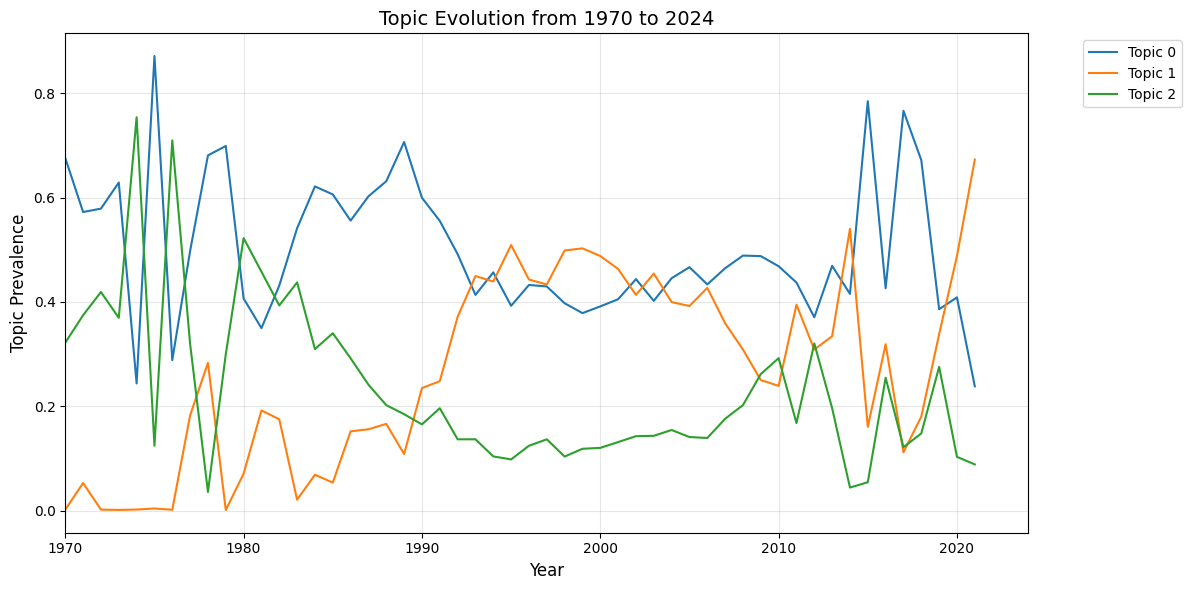

In [63]:
# Set your time window
start_year = 1970  # Replace with your X value
end_year = 2024  # Replace with your Y value

# Filter data for selected years
year_subset = year_topics.loc[start_year:end_year]

# Create individual topic evolution plots
plt.figure(figsize=(12, 6))
for topic_id in range(final_lda_model.num_topics):
    plt.plot(year_subset.index, 
             year_subset[topic_id], 
             label=f"Topic {topic_id}")

plt.title(f"Topic Evolution from {start_year} to {end_year}", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Topic Prevalence", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xlim(start_year, end_year)  # Force x-axis limits
plt.tight_layout()
plt.savefig('topic_evolution_topic_wise.png')
plt.show()

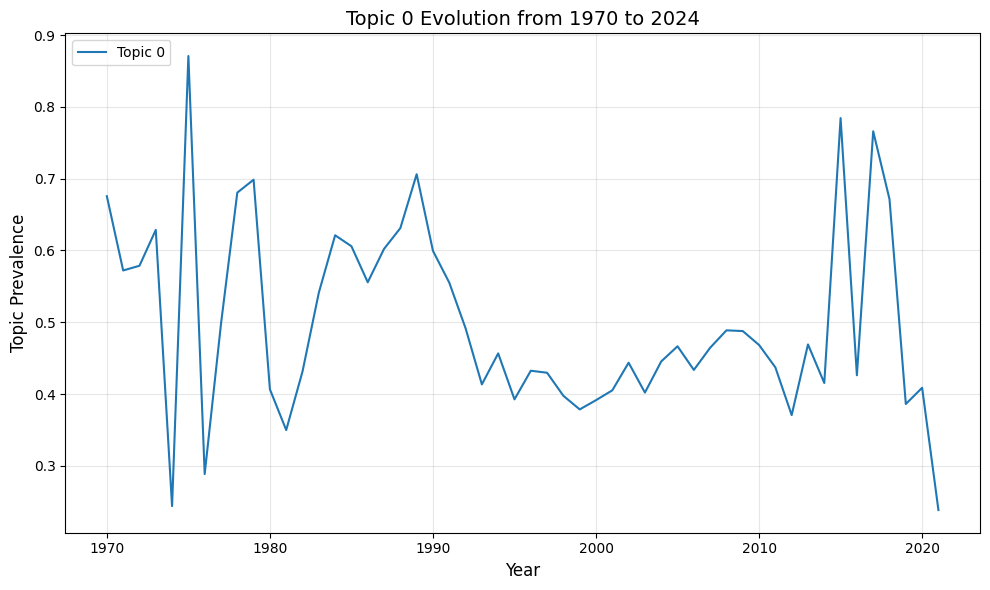

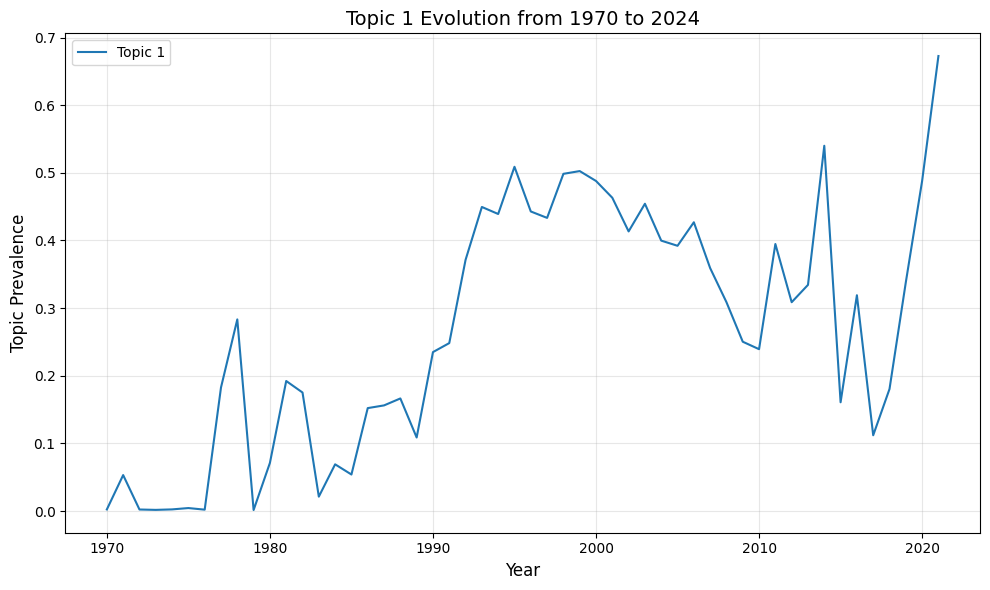

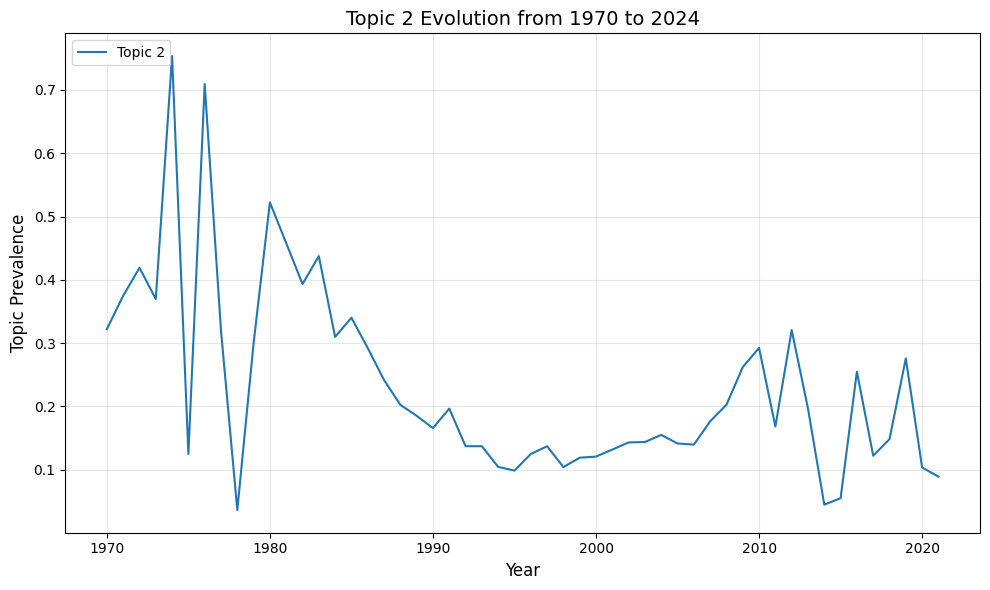

In [65]:
import matplotlib.pyplot as plt

for topic_id in range(final_lda_model.num_topics):
    plt.figure(figsize=(10, 6))
    plt.plot(year_subset.index, 
             year_subset[topic_id], 
             label=f"Topic {topic_id}")
    plt.title(f"Topic {topic_id} Evolution from {start_year} to {end_year}", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Topic Prevalence", fontsize=12)
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'topic{topic_id}_evolution.png')
    plt.show()